# Modelo de reconocimiento de letras

Por medio del uso del dataset que se encuentra en [keggle](https://www.kaggle.com/datasets/landlord/handwriting-recognition?resource=download), se desea construir un modelo de inteligencia artificial que proporcione la capacidad de analizar entrada de escritura a mano por medio de una entrada por mouse (Para esto se usará tensorflow.js que permite exportar el modelo para usarlo en el navegador de forma sencilla).

## Entrenamiento de dígitos

Para poder entrenar el modelo en el reconocimiento de letras individuales se usará la base de datos [EMNIST](https://www.kaggle.com/datasets/crawford/emnist?resource=download) lo cual nos ayudará a posteriormente entrenar el model en identificar las letras de cada uno de las palabras.

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tf_keras import layers, losses, models, metrics

layers.Flatten()

DATASET_JONAS = "dataset/archive"

2024-04-26 07:44:28.219389: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 07:44:28.222551: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 07:44:28.259144: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 07:44:29.196912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def normalize(image):
    return image/255.

def grafic(modelo):
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.plot(modelo.history["loss"], label="Datos de entrenamiento")
    plt.plot(modelo.history["val_loss"], label="Datos de prueba")
    plt.legend(loc="upper right")
    plt.ylim([0,1])
    plt.show()

In [3]:
# Modelo
m = models.Sequential(layers=[
    layers.Flatten(input_shape=(784,)),
    layers.Dense(125, activation='relu'),
    layers.Dropout(0.03), # Para evitar el overfitting
    layers.Dense(125, activation='relu'),
    layers.Dropout(0.03),
    layers.Dense(125, activation='relu'),
    layers.Dropout(0.03),
    layers.Dense(27, activation='softmax')])

m.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[metrics.SparseCategoricalAccuracy()])

In [4]:
df_train = pd.read_csv(os.path.join(DATASET_JONAS, "emnist-letters-train.csv"), header=None)
df_train = df_train.sample(frac=1)
df_train_label = df_train.pop(0)
num_train = df_train.__len__()
df_train = df_train.map(normalize)
df_train

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
80680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_test = pd.read_csv(os.path.join(DATASET_JONAS, "emnist-letters-test.csv"), header=None)
df_test = df_test.sample(frac=1)
df_test_label = df_test.pop(0)
df_test = df_test.map(normalize)
df_test

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
14107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
historial = m.fit(df_train, df_train_label, epochs=5, validation_data=[df_test, df_test_label])

Epoch 1/5


2024-04-26 07:44:51.847832: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 556953600 exceeds 10% of free system memory.
/home/jonasaray/Documents/UCAB/Decimo/Inteligencia artificial/Proyecto/LetterRecognition/venv/lib/python3.12/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2754/2775 [============================>.] - ETA: 0s - loss: 0.7805 - sparse_categorical_accuracy: 0.7609

/home/jonasaray/Documents/UCAB/Decimo/Inteligencia artificial/Proyecto/LetterRecognition/venv/lib/python3.12/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2775/2775 [==============================] - 16s 2ms/step - loss: 0.7784 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.5140 - val_sparse_categorical_accuracy: 0.8331
Epoch 2/5
2775/2775 [==============================] - 4s 2ms/step - loss: 0.4401 - sparse_categorical_accuracy: 0.8586 - val_loss: 0.4251 - val_sparse_categorical_accuracy: 0.8599
Epoch 3/5
2775/2775 [==============================] - 4s 2ms/step - loss: 0.3704 - sparse_categorical_accuracy: 0.8800 - val_loss: 0.3870 - val_sparse_categorical_accuracy: 0.8720
Epoch 4/5
2775/2775 [==============================] - 4s 2ms/step - loss: 0.3316 - sparse_categorical_accuracy: 0.8898 - val_loss: 0.3865 - val_sparse_categorical_accuracy: 0.8738
Epoch 5/5
2775/2775 [==============================] - 4s 2ms/step - loss: 0.3029 - sparse_categorical_accuracy: 0.8974 - val_loss: 0.3770 - val_sparse_categorical_accuracy: 0.8747


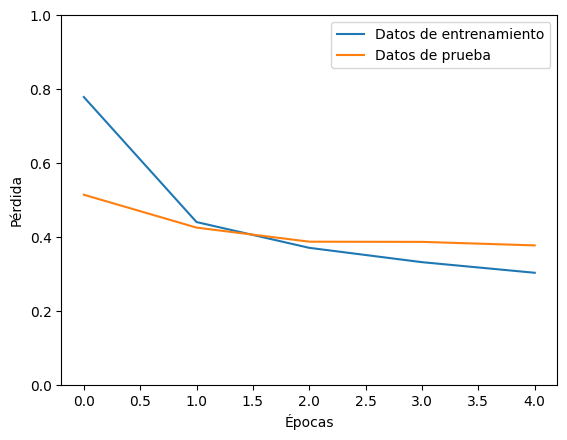

In [7]:
grafic(historial)

## Exportando el modelo

Una vez que el modelo haya sido entrenado ahora necesitamos exportarlo para hacer uso del mismo dentro del ámbito en desarrollo.

In [16]:
m.save(filepath="trainedModel/handwritting.h5")

/home/jonasaray/Documents/UCAB/Decimo/Inteligencia artificial/Proyecto/LetterRecognition/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
